In [163]:
import numpy as np
import pandas as pd
import csv
import pickle
from transposeToDummy import transposeToDummy
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [164]:
# Data initialization
sigma=np.array([[1,0],[0,1]])
beta_mu=np.array([[1,0],[0,1]])

In [165]:
# Linear combination function
def linear_combination(a):
    global sigma, beta_mu
    numerator=a.T@beta_mu@a
    denominator=a.T@sigma@a
    if denominator==0:
        return 0
    # We have minimzer. So, we need to return negative value
    return -numerator/denominator
    

In [166]:
random_seed=42

In [167]:
# Load data
path='Data/'
df=pd.read_csv(path+'eq2015_modify_category.csv')

In [171]:
# reduce the size of the data
#df=df.sample(frac=0.1, random_state=random_seed)

In [172]:
# Split the dataframe into training and testing sets
df, test_df = train_test_split(df, test_size=0.2, random_state=random_seed)

# Print the shapes of the resulting dataframes
print("Training set shape:", df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (604777, 15)
Testing set shape: (151195, 15)


In [173]:
# Split by label
grouped_data = df.groupby('damage_level')

# Initialize variables
S_ms=[]
mu_ms=[]
total_ms=0
msdf=df.drop(columns=['damage_level'])
msdf=transposeToDummy(msdf,toNumpy=False)
total_mean=msdf.mean()


for label, data in grouped_data:
    # drop damage_level column
    data=data.drop(columns=['damage_level'])
    
    # transpose to dummy
    data=transposeToDummy(data,toNumpy=False)
    
    # calculate S_m
    S_ms.append((data.shape[0]-1)*data.cov())
    total_ms+=data.shape[0]-1

    # calculate mu_m
    mean_ms=data.mean()-total_mean
    mean_ms=mean_ms.to_frame()
    mu_ms.append((data.shape[0])*(mean_ms @ mean_ms.T))
    
# calculate sigma
sigma_ms=sum(S_ms)/total_ms

# calculate beta_mu
beta_mu_ms=sum(mu_ms)/(total_ms+len(grouped_data))


In [175]:
# convert to numpy
sigma=sigma_ms.to_numpy()
beta_mu=beta_mu_ms.to_numpy()

In [176]:
# Generate an array with uniform random numbers between 0 and 1
a = np.random.uniform(size=len(sigma))


In [177]:
# Maximize the vale
result=minimize(linear_combination,a)

In [178]:
# Save the result
if result.success:
    print("Optimization successful")

    # Get the current time
    current_time = time.localtime()

    # Extract the day, hour, minute, and second
    day = current_time.tm_mday
    hour = current_time.tm_hour
    minute = current_time.tm_min
    second = current_time.tm_sec

    pickle.dump(result, open(f"mult_result_{day}_{hour}_{minute}_{second}.pkl", "wb"))

Optimization successful


In [179]:
print(result.x)

[-4.45726635e+02  8.89647461e+02 -5.52811897e+01 -6.35738506e+01
 -4.71686621e+02  1.11379816e+03 -3.09769306e-01 -1.75488339e+01
  6.84299523e+00  9.08727853e+00 -1.13868183e+01  1.26159580e+01
  6.13396399e+00 -1.47162820e+01  1.33188218e+00 -3.33966720e-01
 -1.91825960e+01]


In [180]:
# Create PCA for plotting
pca = PCA(n_components=2)

# Normalize the data
scaler=StandardScaler()
df_scaled=scaler.fit_transform(msdf)

# Fit the PCA model to your data
pca.fit(df_scaled)

PCA(n_components=2)

In [181]:
def getLineCoordination(a,x_max,y_max,x_min,y_min):
    # Initialize the variables
    x_start=0
    x_end=0
    y_start=0
    y_end=0

    # When atleast one coordiantion is zero
    if a[0]==0 or a[1]==0:
        if a[0]==0:
            x_start=0
            x_end=0
            y_start=y_min
            y_end=y_max
        else:
            x_start=x_min
            x_end=x_max
            y_start=0
            y_end=0
        return x_start,x_end,y_start,y_end
    
    # Calculate the line
    line_ratio=a[0]/a[1]
    x_size=(x_max-x_min)
    y_size=(y_max-y_min)
    plot_ratio=x_size/y_size
    if plot_ratio>line_ratio:
        x_start=x_min
        x_end=x_max
        y_start=(x_min*a[1])/a[0]
        y_end=(x_max*a[1])/a[0]
    else:
        x_start=(y_min*a[0])/a[1]
        x_end=(y_max*a[0])/a[1]
        y_start=y_min
        y_end=y_max
    
    # Return the result
    return x_start,x_end,y_start,y_end

c:\Users\49228\anaconda3\envs\multilayer\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\49228\anaconda3\envs\multilayer\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\49228\anaconda3\envs\multilayer\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\49228\anaconda3\envs\multilayer\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


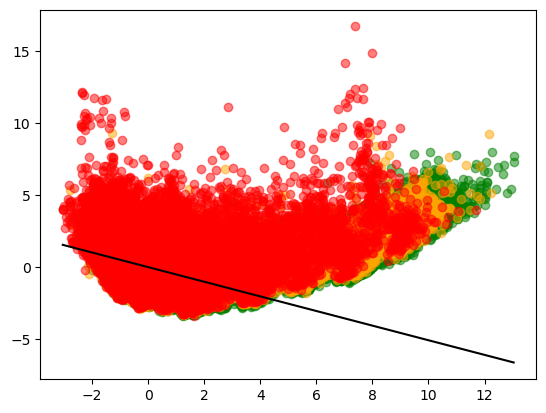

In [182]:
colors=['green','orange','red']
x_s=[]
y_s=[]
for label, data in grouped_data:
    # drop damage_level column
    data=data.drop(columns=['damage_level'])
    
    # transpose to dummy
    data=transposeToDummy(data)
    
    # Normalize the data
    data_scaled=scaler.transform(data)
    
    # Transform the data using the fitted PCA model
    transformed_data = pca.transform(data_scaled)
    

    x_s.append(transformed_data[:, 0])
    y_s.append(transformed_data[:, 1])
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], color=colors[label-1],alpha=0.5)



# Calculate the vector line
end_point = result.x
end_point_scaled=scaler.transform(end_point.reshape(1, -1))
end_point_pca=pca.transform(end_point_scaled)

# Get Min and Max values
x_max=max(max(x) for x in x_s)
y_max=max(max(y) for y in y_s)
x_min=min(min(x) for x in x_s)
y_min=min(min(y) for y in y_s)

# Get the line coordination
x_start,x_end,y_start,y_end=getLineCoordination(end_point_pca[0],x_max,y_max,x_min,y_min)


# Plot the vector line
plt.plot([x_start, x_end], [y_start, y_end],color='black')

# show plot
plt.show()

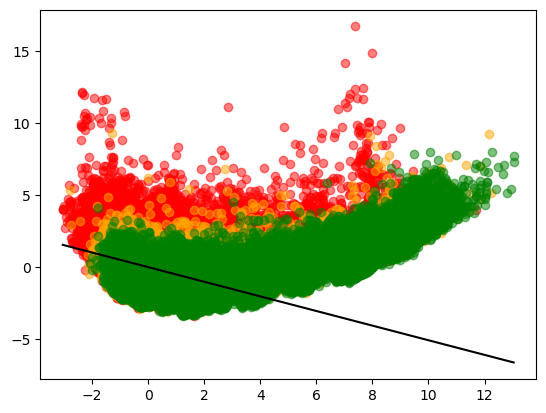

In [183]:
for i in [2,1,0]:
    plt.scatter(x_s[i], y_s[i], color=colors[i],alpha=0.5)

# Plot the vector line
plt.plot([x_start, x_end], [y_start, y_end],color='black')

# show plot
plt.show()

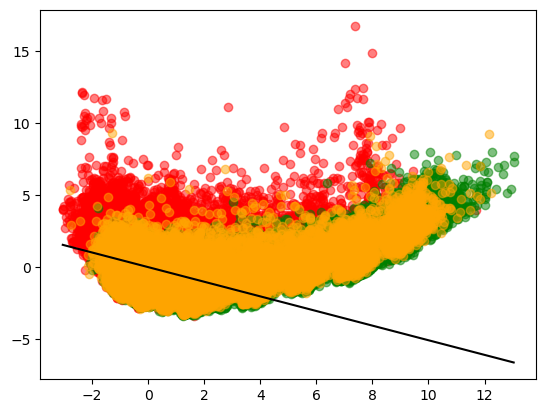

In [184]:
for i in [2,0,1]:
    plt.scatter(x_s[i], y_s[i], color=colors[i],alpha=0.5)

# Plot the vector line
plt.plot([x_start, x_end], [y_start, y_end],color='black')

# show plot
plt.show()